In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set_style("whitegrid")
N_EPOCHS = 200
ARCHITECTURES = [
    [64, 32],
    [128, 64, 32],
    [256, 128, 64, 32],
    [256, 128, 64],
    [64, 64, 64],
    [64, 64, 64, 64],
    [64, 64, 64, 64, 64],
    [128, 128],
    [128, 128, 128],
    [32, 32, 32, 32, 32],
]

In [2]:
banerji_raw = pd.read_csv('Banerji-Berry-Shotland_2017_AEJ.csv')
print(banerji_raw)

       treatment  age  state  bl_caser_total_norm  caser_total_norm  boy  \
0              2    8      1             1.954451          1.881699    1   
1              2    6      1             0.310986          1.389131    1   
2              2    4      1            -0.759177         -0.545960    1   
3              2    7      1            -0.759177          0.333626    1   
4              2    8      1             0.502087          0.650278    1   
...          ...  ...    ...                  ...               ...  ...   
14569          3    8      2             0.119886          0.298443    0   
14570          3    5      2            -0.712464         -0.862612    1   
14571          3    8      2            -0.653010         -0.721878    0   
14572          3    6      2            -0.912057         -0.897795    0   
14573          3    6      2            -0.720957          0.333626    1   

       number_of_kids  mother_educ  factor_educ  mother_age30  farmingIncome  
0       

In [ ]:

def prepare_data(df):
    """
    Prepares the dataset by encoding categorical variables and splitting features and target.

    Args:
        df (pd.DataFrame): The raw dataset.

    Returns:
        X (np.ndarray): The feature matrix.
        Y (np.ndarray): The target vector.
    """
    Y = df['caser_total_norm'].values

    X = df.drop(['caser_total_norm', 'bl_caser_total_norm'], axis=1)

    categorical_vars = ['treatment', 'state', 'boy', 'mother_educ', 'factor_educ', 'mother_age30', 'farmingIncome']

    X['age'] = pd.to_numeric(X['age'], errors='coerce')
    X['number_of_kids'] = pd.to_numeric(X['number_of_kids'], errors='coerce')

    X = pd.get_dummies(X, columns=categorical_vars, drop_first=True)

    if X.isnull().any().any():
        print("There are missing values in X. Filling missing values with column mean.")
        X = X.fillna(X.mean())

    try:
        X = X.astype(np.float32)
    except ValueError as e:
        print("Error converting X to float32:", e)
        print("Identifying columns that cannot be converted:")
        for col in X.columns:
            if X[col].dtype == 'object':
                print(f"Column '{col}' has data type object. Unique values:")
                print(X[col].unique())
                X[col] = pd.to_numeric(X[col], errors='coerce')
                if X[col].isnull().any():
                    print(f"After conversion, column '{col}' contains NaN values. Filling with column mean.")
                    X[col] = X[col].fillna(X[col].mean())
        X = X.astype(np.float32)

    X = X.values
    Y = Y.astype(np.float32)

    return X, Y

class BanerjiDataset(Dataset):
    """
    Custom dataset for the Banerji et al. data.
    """
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

def build_model(input_size, hidden_layers, activation_fn=nn.ReLU()):
    """
    Builds a neural network model with the specified architecture.

    Args:
        input_size (int): The number of input features.
        hidden_layers (list): A list containing the number of units in each hidden layer.
        activation_fn (nn.Module): The activation function to use.

    Returns:
        model (nn.Sequential): The neural network model.
    """
    layers = []
    in_size = input_size
    for hidden_size in hidden_layers:
        layers.append(nn.Linear(in_size, hidden_size))
        layers.append(activation_fn)
        in_size = hidden_size
    layers.append(nn.Linear(in_size, 1))
    model = nn.Sequential(*layers)
    return model

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    """
    Trains the model and keeps track of the best performing model on validation data.
    Also records training and validation losses for plotting.

    Returns:
        model (nn.Module): The trained model with the best validation performance.
        best_loss (float): The best validation loss achieved.
        history (dict): Dictionary containing lists of training and validation losses.
    """
    best_model = None
    best_loss = np.inf
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_batch, Y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, Y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)
        epoch_train_loss = running_loss / len(train_loader.dataset)
        history['train_loss'].append(epoch_train_loss)

        val_loss = evaluate_model(model, val_loader, criterion)
        history['val_loss'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()

    model.load_state_dict(best_model)
    return model, best_loss, history

def evaluate_model(model, val_loader, criterion):
    """
    Evaluates the model on validation data.

    Args:
        model (nn.Module): The neural network model.
        val_loader (DataLoader): DataLoader for validation data.
        criterion (nn.Module): The loss function.

    Returns:
        avg_loss (float): The average validation loss.
    """
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X_batch, Y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, Y_batch)
            total_loss += loss.item() * X_batch.size(0)
    avg_loss = total_loss / len(val_loader.dataset)
    return avg_loss

def run_experiments(X_train, Y_train, X_val, Y_val, architectures, num_epochs=50, batch_size=32):
    """
    Runs experiments with different neural network architectures.

    Returns:
        results_df (pd.DataFrame): DataFrame containing architecture and validation loss.
        histories (dict): Dictionary of training histories for each architecture.
    """
    results = []
    histories = {}
    input_size = X_train.shape[1]

    train_dataset = BanerjiDataset(X_train, Y_train)
    val_dataset = BanerjiDataset(X_val, Y_val)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    for arch in architectures:
        print(f"Training model with architecture: {arch}")
        model = build_model(input_size, hidden_layers=arch)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters())

        model, val_loss, history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

        arch_name = '-'.join(map(str, arch))
        results.append({
            'architecture': arch,
            'validation_loss': val_loss
        })
        histories[arch_name] = history

    results_df = pd.DataFrame(results)
    return results_df, histories

if __name__ == "__main__":
    banerji_raw = pd.read_csv('Banerji-Berry-Shotland_2017_AEJ.csv')
    X, Y = prepare_data(banerji_raw)
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
    results, histories = run_experiments(X_train, Y_train, X_val, Y_val, ARCHITECTURES, num_epochs=N_EPOCHS)
    best_architecture = results.loc[results['validation_loss'].idxmin(), 'architecture']
    best_arch_name = '-'.join(map(str, best_architecture))
    best_history = histories[best_arch_name]

In [ ]:
results.to_csv('q3j-results/summary_of_validation_loss_by_architecture.csv', index=False)
(
    results
    .assign(architecture=lambda df: df.architecture.map(lambda x: str(x).replace("[", "").replace("]", "").replace(", ", "-")))
    .set_axis(['Architecture', 'Validation Loss'], axis=1)
    .sort_values('Validation Loss')
    .to_latex('q3j-results/summary_of_validation_loss_by_architecture.tex', index=False)
)
history_training_validation_loss = pd.concat(
    [pd.DataFrame(histories[arch]).assign(arch=arch) for arch in histories.keys()],
    axis=0
)
history_training_validation_loss.to_csv('q3j-results/history_training_validation_loss.csv', index=False)

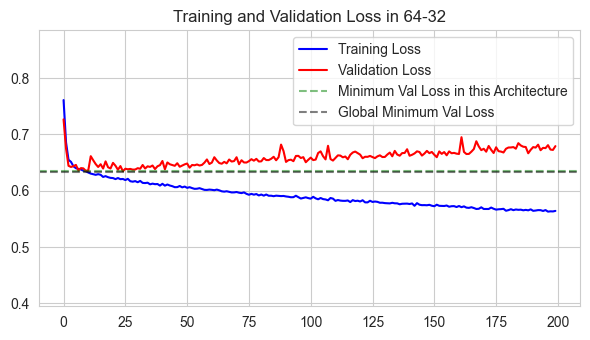

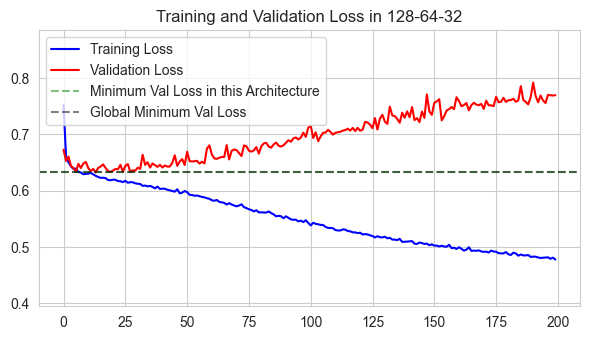

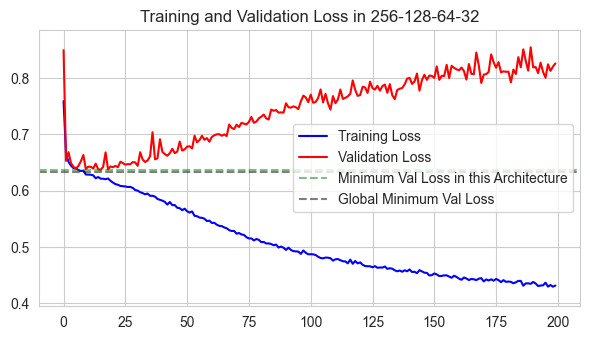

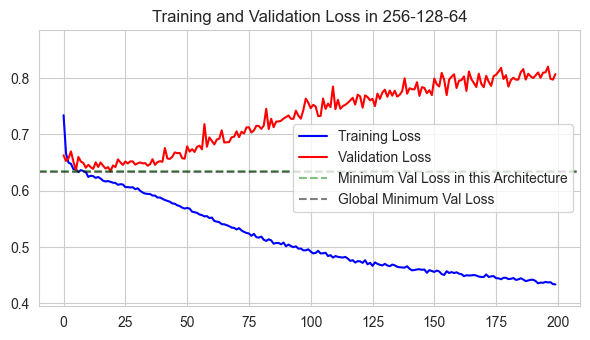

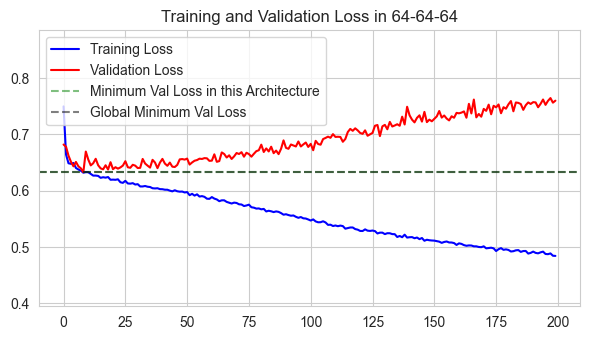

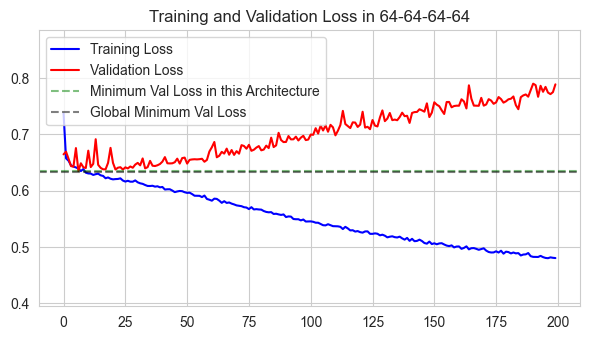

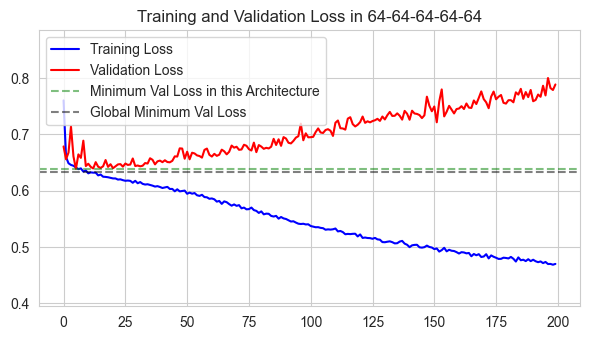

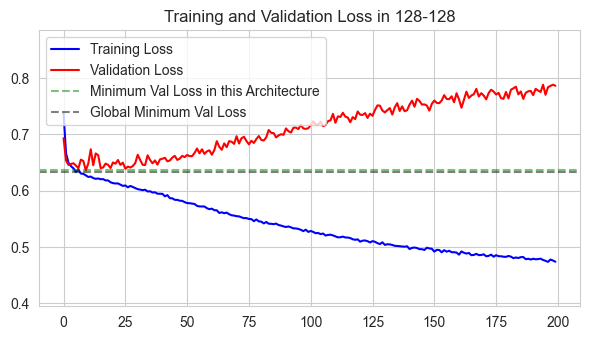

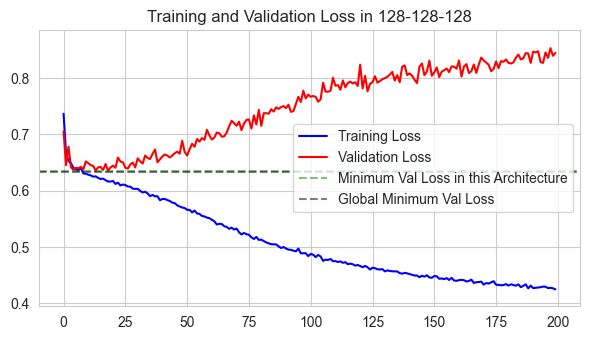

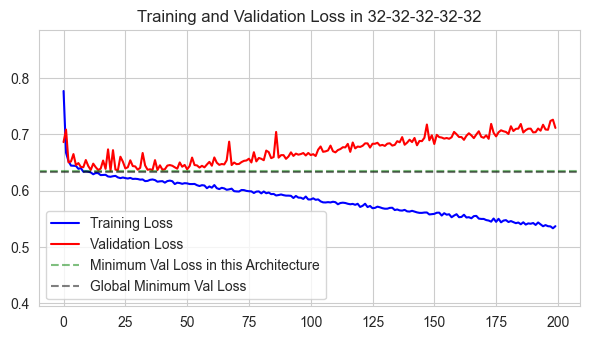

In [3]:
history_training_validation_loss = pd.read_csv('q3j-results/history_training_validation_loss.csv')

max_loss = history_training_validation_loss.max().drop('arch').max()
min_loss = history_training_validation_loss.min().drop('arch').min()
min_val_loss = history_training_validation_loss.val_loss.min()
VAREPSILON = .03

for arch in history_training_validation_loss.arch.unique():
    history_arch = history_training_validation_loss.loc[lambda df: df.arch == arch]
    history_arch.reset_index(inplace=True, drop=True)
    plt.figure(figsize=(6, 3.5))
    plt.plot(history_arch.index, history_arch.train_loss, label='Training Loss', color='blue', marker='')
    plt.plot(history_arch.index, history_arch.val_loss, label='Validation Loss', color='red', marker='')
    plt.axhline(y=history_arch.val_loss.min(), linestyle='--', color='green', alpha=0.5, label='Minimum Val Loss in this Architecture') 
    plt.axhline(y=min_val_loss, linestyle='--', color='black', alpha=0.5, label='Global Minimum Val Loss')
    plt.title(f'Training and Validation Loss in {arch}')
    plt.ylim(min_loss - VAREPSILON, max_loss + VAREPSILON)
    plt.tight_layout()
    plt.legend()
    plt.savefig(f'q3j-plots/training_validation_loss_by_epoch_arch_{arch.replace("-", "_")}.png')
    plt.show()